<a href="https://colab.research.google.com/github/falniir/IE500618-Machinelearning/blob/master/Alexnet_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

In [12]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

In [13]:
# transform data into a representation that tensorflow is familiar with
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

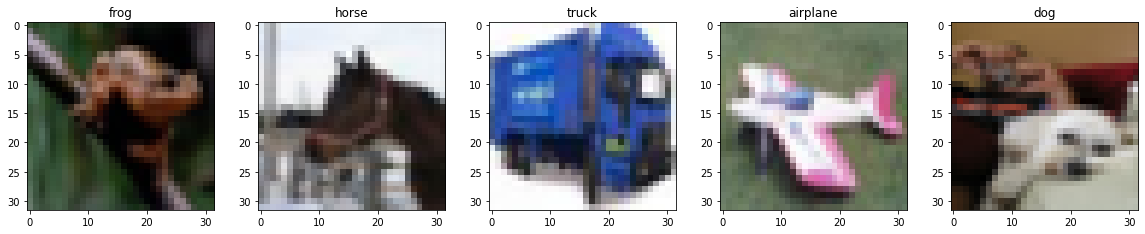

In [14]:
# Visualize images from the CIFAR-10 dataset
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])

In [15]:
# Process images as AlexNet expects 277x*277 grid images
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (64,64))
    return image, label

In [16]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


In [17]:
# pipeline with preprocessing, shuffling and batch
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

In [18]:
# Create model
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
    
    
])

In [19]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.1),
    metrics=['accuracy']    
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        11648     
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 batch_normalization_6 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                      

In [20]:
# Training
model.fit(train_ds, epochs=10, validation_data=validation_ds, validation_freq=1, callbacks=[tensorboard_cb])

Epoch 1/10
1406/1406 [==============================] - 77s 51ms/step - loss: 1.8850 - accuracy: 0.3013 - val_loss: 1.5573 - val_accuracy: 0.4293
Epoch 2/10
1406/1406 [==============================] - 78s 53ms/step - loss: 1.5863 - accuracy: 0.4305 - val_loss: 1.4089 - val_accuracy: 0.4902
Epoch 3/10
1406/1406 [==============================] - 78s 53ms/step - loss: 1.4380 - accuracy: 0.4939 - val_loss: 1.2290 - val_accuracy: 0.5691
Epoch 4/10
1406/1406 [==============================] - 77s 52ms/step - loss: 1.3317 - accuracy: 0.5400 - val_loss: 1.2707 - val_accuracy: 0.5591
Epoch 5/10
1406/1406 [==============================] - 76s 52ms/step - loss: 1.2472 - accuracy: 0.5738 - val_loss: 1.0805 - val_accuracy: 0.6394
Epoch 6/10
1406/1406 [==============================] - 80s 54ms/step - loss: 1.1715 - accuracy: 0.6040 - val_loss: 1.1456 - val_accuracy: 0.6090
Epoch 7/10
1406/1406 [==============================] - 81s 55ms/step - loss: 1.1040 - accuracy: 0.6317 - val_loss: 1.0076 -